# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [7]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


### Refined Simulation

Defining local area

In [8]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.0

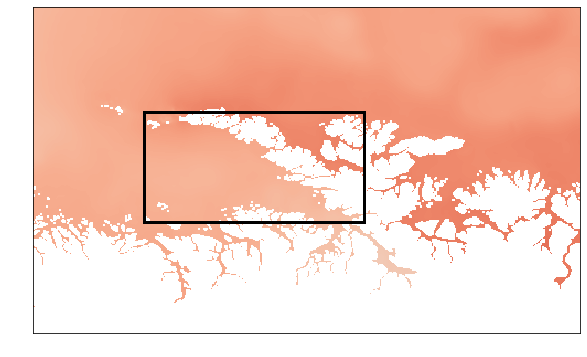

In [9]:
parent_eta, parent_hu, parent_hv = sim.download(interior_domain_only=True)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(parent_eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='black', facecolor='none', lw=3)
ax.add_patch(area)

Init Child

In [10]:
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


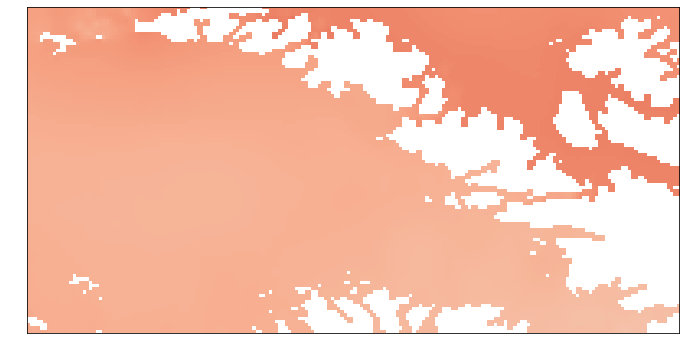

In [11]:
child_eta, chiild_hu, child_hv = sim.children[0].download(interior_domain_only=True)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(child_eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

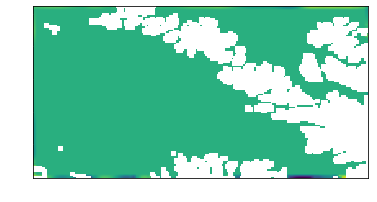

In [12]:
plt.imshow(sim.bathymetry.download(sim.gpu_stream)[0][ loc[0][0] : loc[1][0]+5, loc[0][1] : loc[1][1]+5 ] - sim.children[0].bathymetry.download(sim.children[0].gpu_stream)[0])

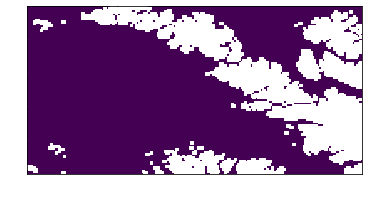

In [13]:
plt.imshow(parent_eta[ loc[0][0] : loc[1][0], loc[0][1] : loc[1][1] ] - child_eta)

### Evolve parent together with child

In [14]:
from gpuocean.SWEsimulators import CDKLM16

ref_sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [15]:
ref_sim.step(360)

ref_eta, ref_hu, ref_hv = ref_sim.download()

In [16]:
sim.step(360)

eta, hu, hv = sim.download()

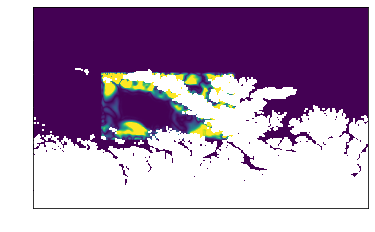

In [17]:
plt.imshow(np.abs(ref_eta-eta), vmax=0.05)

In [18]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim.children[0].download(interior_domain_only=True)

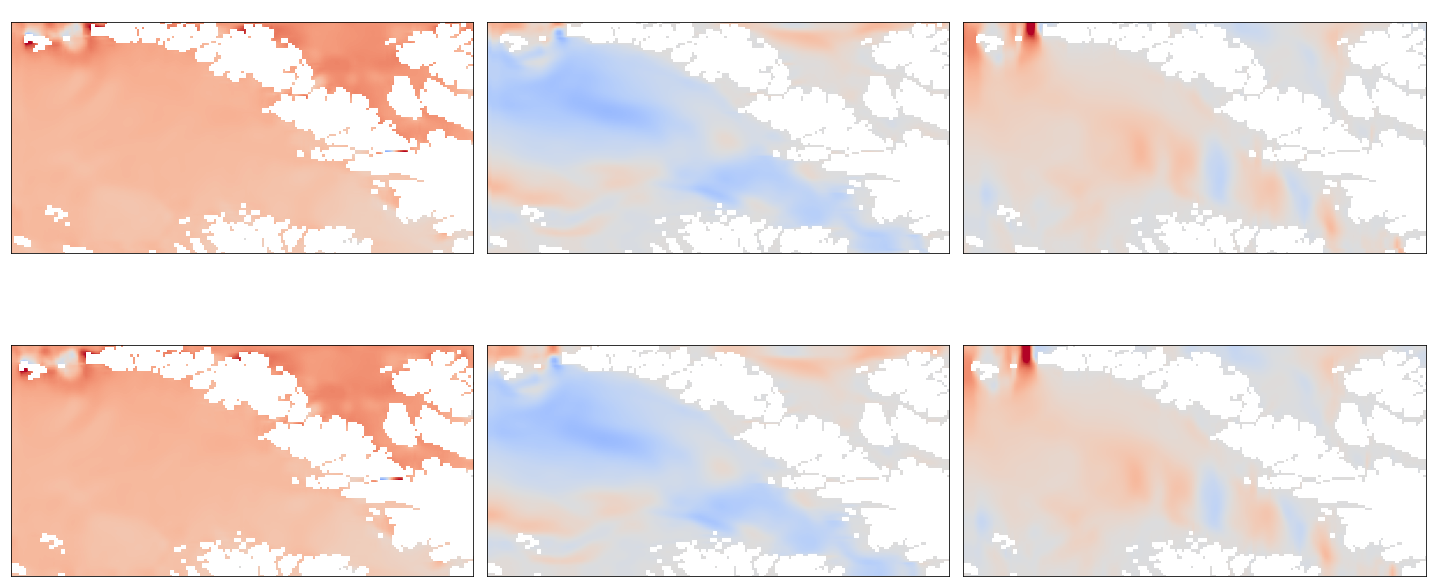

In [19]:
fig, axs = plt.subplots(2,3,figsize=(20,10))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

plt.tight_layout()